In [1]:
import sys
sys.path.insert(0, "/Users/rstiskalek/Projects/candel")

from os.path import join
import numpy as np
from h5py import File
import matplotlib.pyplot as plt
import candel

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
mock_dir = "/mnt/home/rstiskalek/ceph/CANDEL/data/CF4_mock"
CF4 = candel.pvdata.load_CF4_data("/mnt/home/rstiskalek/ceph/CANDEL/data/CF4", which_band="w1",)

2025-05-23 21:53:51 initially loaded 9788 galaxies from CF4 TFR data.
2025-05-23 21:53:51 removed 6537 galaxies, thus 3251 remain.


In [3]:
distmod2dist = candel.Distmod2Distance()
distmod2redshift = candel.Distmod2Redshift()
log_grad_distmod2dist = candel.LogGrad_Distmod2ComovingDistance()

field_loader = candel.field.name2field_loader("Carrick2015")(
    path_density="/mnt/home/rstiskalek/ceph/CANDEL/data/fields/carrick2015_twompp_density.npy",
    path_velocity="/mnt/home/rstiskalek/ceph/CANDEL/data/fields/carrick2015_twompp_velocity.npy"
    )

In [8]:
kwargs = {
    'Vext_mag': 210,
    'Vext_ell': 295,
    'Vext_b': -10,
    'sigma_v': 270,
    'a_TFR': -19.72,
    'b_TFR': -10,
    'c_TFR': 12,
    'sigma_TFR': 0.32,
    'a_TFR_dipole_mag': None,
    'a_TFR_dipole_ell': 142.0,
    'a_TFR_dipole_b': 52.0,
    'alpha': 1.5,
    'beta': 0.43,
    'h': 1,
    'mag': CF4['mag'] - 0.05,
    'eta': CF4['eta'],
    'mag_min': 7.5,
    'mag_max': 16.5,
    'e_mag': 0.05,
    'eta_mean': 0.0,
    'eta_std': 0.125,
    'e_eta': 0.023,
    'b_min': 7.5,
    'zcmb_max': 0.05,
    'r_h_max': 500,
    'distmod2dist': distmod2dist,
    'distmod2redshift': distmod2redshift,
    'log_grad_distmod2dist': log_grad_distmod2dist,
    'field_loader': field_loader,
    'use_data_prior': True,
    'rmin_reconstruction': 0.1,
    'rmax_reconstruction': 250,
    'num_steps_reconstruction':501,
}


In [9]:
nsamples = 1001
fname = join(mock_dir, "mock_0.hdf5")

mock = candel.mock.gen_CF4_TFR_mock(nsamples, seed=30, **kwargs)

2025-05-23 21:59:39 interpolating the density field...
2025-05-23 21:59:42 interpolating the velocity field...
2025-05-23 21:59:48 interpolating the density field...
2025-05-23 21:59:49 interpolating the velocity field...
2025-05-23 21:59:54 Rejecting 2 samples with zcmb > 0.05


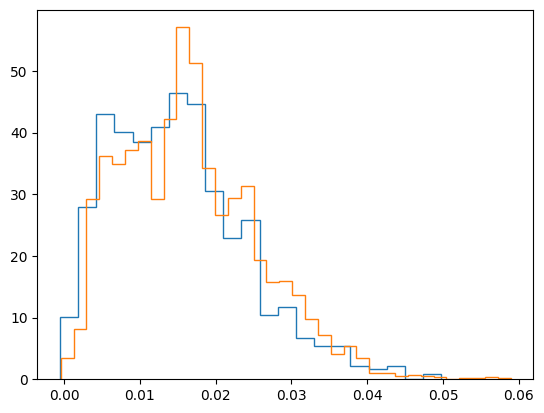

In [10]:
plt.figure()
plt.hist(mock["zcmb"], bins="auto", density=1, histtype="step", label="mock")
plt.hist(CF4["zcmb"], bins="auto", density=1, histtype="step", label="CF4")
plt.show()

In [ ]:
# print(f"writing `{fname}`.")
# with File(fname, 'w') as f:
#     grp = f.create_group("mock")
#     for key, value in mock.items():
#         grp.create_dataset(key, data=value, dtype=np.float32)

#     for key, value in kwargs.items():
#         if isinstance(value, (float, int, bool)):
#             grp.attrs[key] = value


writing `/mnt/home/rstiskalek/ceph/CANDEL/data/CF4_mock/mock_0.hdf5`.


### Many mocks to test detecting the dipole

In [12]:
nsample_list = [500, 1000]
nseeds_per_nsample = 2

index = 0
records = []

for nsamples in nsample_list:
    for i in range(nseeds_per_nsample):
        seed = 1000 * nsamples + i  # unique, reproducible
        fname = join(mock_dir, f"mock_{index}.hdf5")
        print(f"preparing`{fname}`.")

        mock = candel.mock.gen_CF4_TFR_mock(nsamples, seed=seed, **kwargs)

        with File(fname, 'w') as f:
            grp = f.create_group("mock")
            for key, value in mock.items():
                grp.create_dataset(key, data=value, dtype=np.float32)

            for key, value in kwargs.items():
                if isinstance(value, (float, int, bool)):
                    grp.attrs[key] = value
            grp.attrs["seed"] = seed
            grp.attrs["nsamples"] = nsamples

        records.append((index, nsamples))
        index += 1

# Save index tracking table
records = np.array(records, dtype=int)
header = "index nsamples"
np.savetxt(join(mock_dir, "mock_index.txt"), records, fmt="%d", header=header)

2025-05-23 22:12:21 interpolating the density field...
2025-05-23 22:12:22 interpolating the velocity field...
2025-05-23 22:12:25 interpolating the density field...
2025-05-23 22:12:26 interpolating the velocity field...
2025-05-23 22:12:31 Rejecting 0 samples with zcmb > 0.05
2025-05-23 22:12:31 interpolating the density field...
2025-05-23 22:12:32 interpolating the velocity field...
2025-05-23 22:12:35 interpolating the density field...
2025-05-23 22:12:35 interpolating the velocity field...
2025-05-23 22:12:38 Rejecting 2 samples with zcmb > 0.05
2025-05-23 22:12:38 interpolating the density field...
2025-05-23 22:12:40 interpolating the velocity field...
2025-05-23 22:12:45 interpolating the density field...
2025-05-23 22:12:46 interpolating the velocity field...
2025-05-23 22:12:51 Rejecting 5 samples with zcmb > 0.05
2025-05-23 22:12:51 interpolating the density field...
2025-05-23 22:12:53 interpolating the velocity field...
2025-05-23 22:12:59 interpolating the density field.